In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, json, csv, re, copy

In [3]:
# Formatting
unaccent_list = [('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u')]
romanize_list = [('1', 'i'), ('2', 'ii'), ('3', 'iii'), ('4', 'iv'), ('5', 'v'), ('6', 'vi')]
def unaccent(string):
    for original, replacement in unaccent_list:
        string = string.replace(original, replacement)
    return string

def romanize(string):
    for original, replacement in romanize_list:
        string = string.replace(original, replacement)
    return string

def deabbreviate(string):
    for original, replacement in abreviaturas:
        string = string.replace(original, replacement)
    return string
    
def format_subject_name(subject_name):
    # Using * to mark string start and end.
    subject_name = '*' + str(subject_name).lower().strip() + '*'
    subject_name = romanize(unaccent(subject_name)).replace('.', '')
    # This ones really common.
    if 'laboratorio' in subject_name and not 'laboratorio de' in subject_name:
        subject_name.replace('laboratorio', 'laboratorio de')
        
    #original = subject_name
    # Sometimes we need multiple passes
    for _ in range(3):
        subject_name = deabbreviate(subject_name)
        
    # Sets all spaces to be length one.
    subject_name = re.sub(' +', ' ', subject_name)
    subject_name = subject_name.strip().replace('*', '')
    return subject_name

In [4]:
# I/O
with open('cursos/abreviaturas.csv') as file:
    reader = csv.reader(file)
    abreviaturas = list(reader)[1:]

df_cursos_fisica = pd.read_csv("cursos/cursos_fisica_nombres.csv")
df_cursos_biomedica = pd.read_csv("cursos/cursos_biomedica_nombres.csv")

date = "17-05-25"
filename = 'intersemestrales_estudiantes_17-05-25.csv'
#names = ['tiempo', 'carrera', 'semestre_actual', 'razon', 'cursado_anteriormente',
#         'opcion_1', 'opcion_2', 'opcion_3', 'dificultades', 'calidad', 'justificacion_calidad',
#         'condiciones_exito', 'cambios_organizacion', 'recomendaciones', 'comentarios', 'token']
df = pd.read_csv(filename).fillna('nan')
df.head(2)

,tiempo,carrera,semestre_actual,razon,cursado_anteriormente,opcion_1,opcion_2,opcion_3,dificultades,calidad,justificacion_calidad,condiciones_exito,cambios_organizacion,recomendaciones,comentarios,token
0,17/5/2025 1:16:29,Física,4,Porque no me gusto mi curso anterior,No,EDO I,Electro,nan,Tal vez el tiempo de estudio,3.0,Creo que serían regulares por el tiempo que te...,Creo que si fueran en línea o mixtos facilitar...,"Sí, me gustaría y los tomaría",Pues sería en qué no les quiten sus horas de t...,Ninguno,"###\n{""roles"":{""estudiante"":20252},""id_votació..."
1,17/5/2025 12:05:16,Física,Octavo,LAB. Contemporáneo 1,No,Lab.Contempo 1,Lab.Contempo 1,Lab.contempo 1,Solo el tiempo,5.0,nan,Que sea moduladorio,"Sí, me gustaría y los tomaría",nan,nan,"###\n{""roles"":{""estudiante"":20252},""id_votació..."


In [5]:
df_fisica = df[df['carrera']=='Física']
df_biomedica = df[df['carrera']=='Física Biomédica']

In [32]:
def update_counts(dictionary, key, weight):
    try: dictionary[key] += weight
    except KeyError: dictionary[key] = weight

def update_points(df_carrera, df_cursos, skip_nonmatches=True, weights=(3, 2, 1)):
    resultados = {}
    skipped = 0
    total = 0
    for _, row in df_carrera.iterrows():
        opciones = [format_subject_name(row['opcion_1']),
                    format_subject_name(row['opcion_2']),
                    format_subject_name(row['opcion_3'])]
        for weight, opcion in zip(weights, opciones):
            if opcion == 'nan': continue
            if 'optativa' in opcion or 'opcional' in opcion:
                update_counts(resultados, 'optativas', weight)
                total += 1
                continue
            if not opcion in list(df_cursos['nombre']):
                skipped += 1
                total += 1
                if skip_nonmatches: continue
            if skip_course(opcion): continue
            else:
                update_counts(resultados, opcion, weight)
                total += 1
    resultados = dict(sorted(resultados.items(), key=lambda item: item[1]))
    return resultados, total, skipped

def skip_course(course):
    keywords = ['diferenciales', 'calculo', 'algebra', 'geometria', 'compleja']
    for keyword in keywords:
        if keyword in course: return True
    return False

def plot_results(resultados, total, skipped, carrera, date, weighted=True):
    # Format
    rc_update = {'font.size': 15, 'font.family': 'serif',
				 'font.serif': ['CMU Serif', 'Times New Roman', 'FreeSerif'], 'mathtext.fontset': 'cm'}
    plt.rcParams.update(rc_update)

    # Plotting
    names = [x[0].title() for x in resultados.items()]
    counts = [x[1] for x in resultados.items()]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.barh(names, counts, color='#74bbb6')

    title = f"Materias deseadas para intersemestral por estudiantes de {carrera} ({date})\n" \
            f"Totales: {total}, Saltados: {skipped}"

    xlabel = "Cuentas"
    if weighted: xlabel += "pesadas (Opción 1 * 3, Opción 2 * 2, Opción 3 * 1)"
    ax.set(title=title, xlabel=xlabel)
    ax.grid(True, axis='x', ls='--')

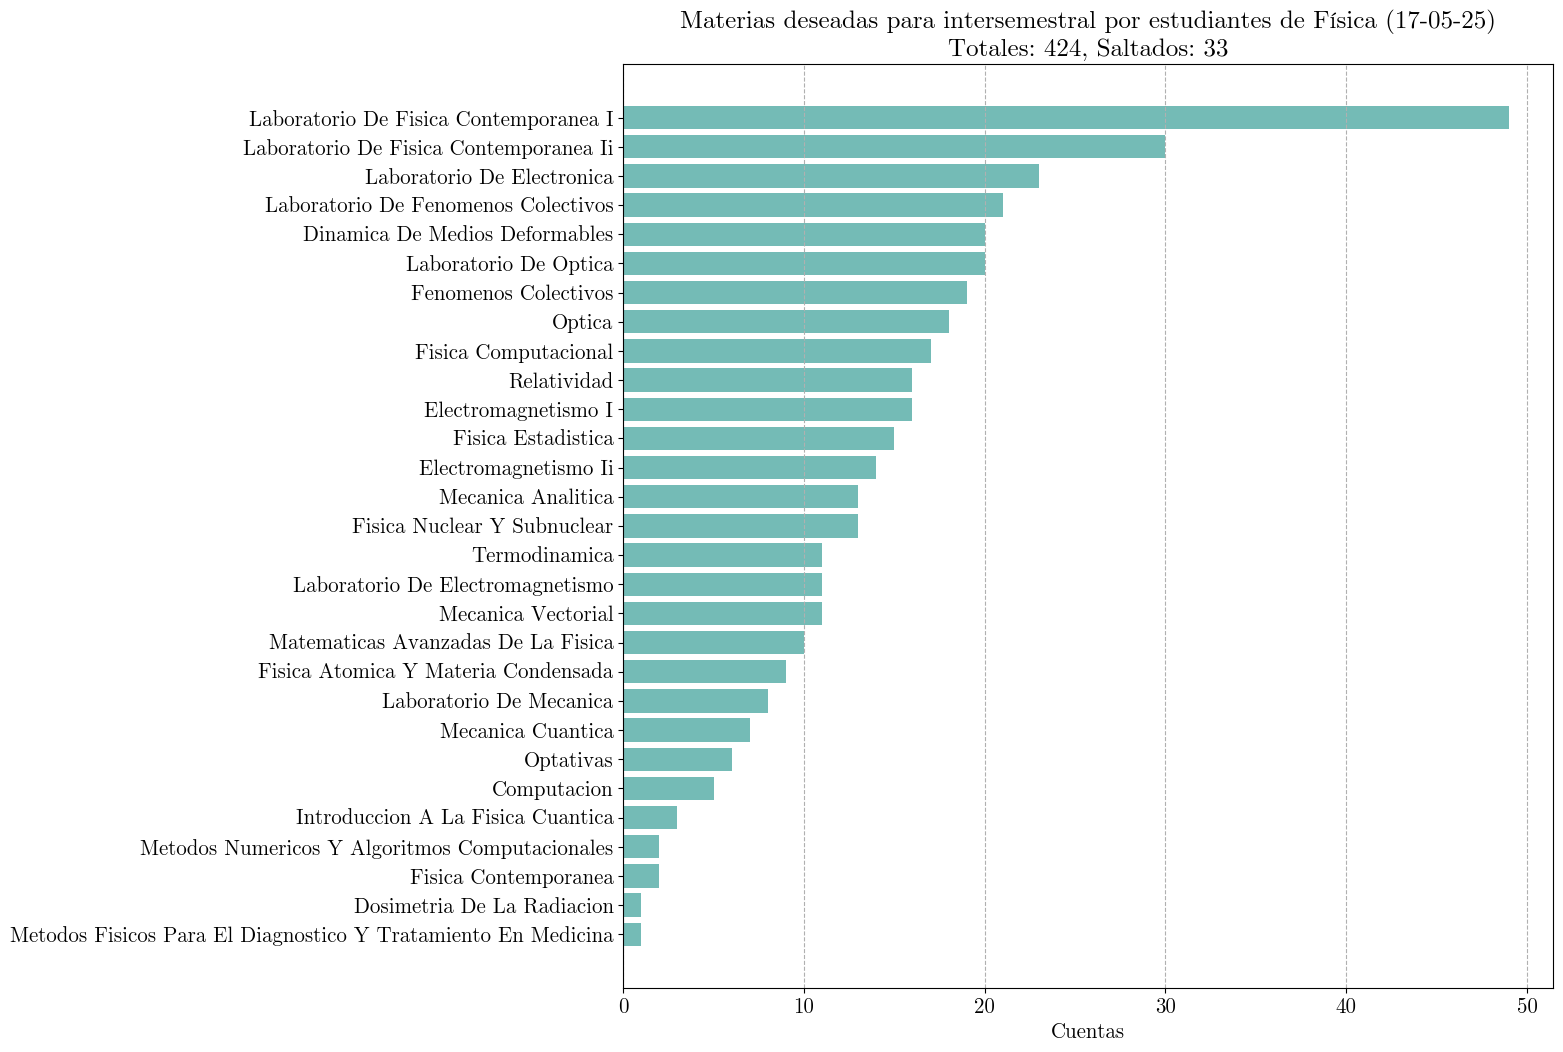

In [35]:
resultados, total, skipped = update_points(df_fisica, df_cursos_fisica, skip_nonmatches=True, weights=(1, 1, 1))
with open('intersemestrales_fisica_unweighted_17-05-25.json', 'w') as file:
    json.dump(resultados, file, indent=4)
    
plot_results(resultados, total, skipped, "Física", date, weighted=False)
plt.savefig('intersemestrales_fisica_unweighted_17-05-25.png', dpi=300, bbox_inches = "tight")

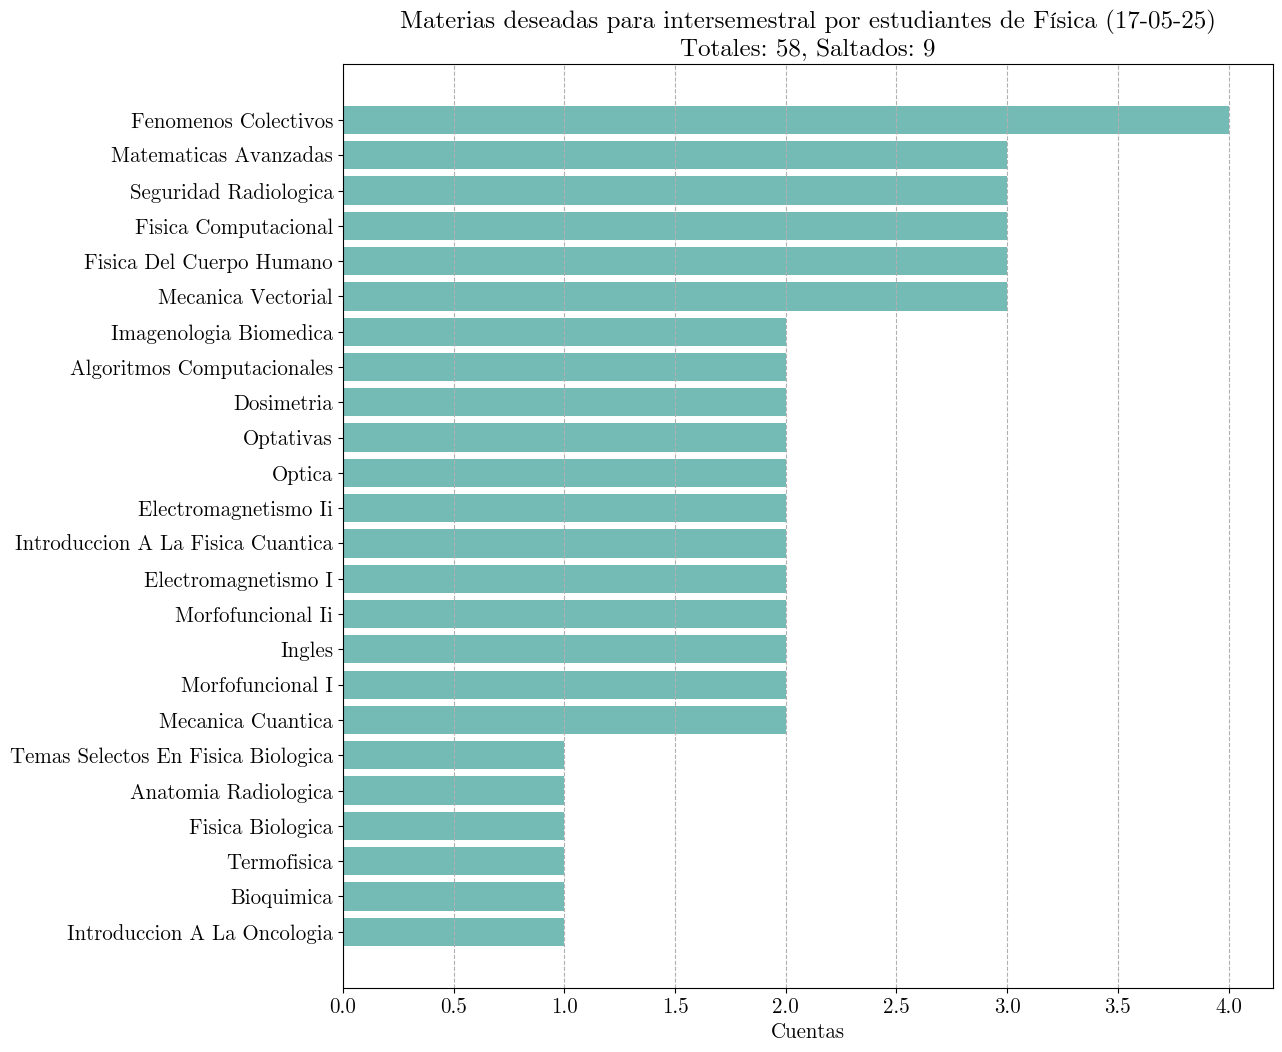

In [37]:
resultados, total, skipped = update_points(df_biomedica, df_cursos_biomedica, skip_nonmatches=True, weights=(1, 1, 1))
with open('intersemestrales_fisica-biomedica_unweighted_17-05-25.json', 'w') as file:
    json.dump(resultados, file, indent=4)
    
plot_results(resultados, total, skipped, "Física", date, weighted=False)
plt.savefig('intersemestrales_fisica-biomedica_unweighted_17-05-25.png', dpi=300, bbox_inches = "tight")